In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from scipy.stats import spearmanr
from scipy.stats import wilcoxon

In [6]:
out_path = '200101_pairwise_between_individuals'
save_images = True

In [7]:
ref_genes = standardizer.reference_genes(10090, 'orp')

In [8]:
pr = properties.genbank_validated_rna(10090)[
    ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})
pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

In [9]:
tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 

In [10]:
def load_data(dataset_name):
    df_data, meta, df_gene = sequencing.load_cached_aging_map(
        dataset_name=dataset_name,
        unambiguous_to_entrez=True, 
        as_entrez=True)

    meta = meta[
        (meta['tissue'].isin(tissues_to_consider)) &
        (meta['pfu']==0) &
        (meta['age']>=4)
    ]
    
    df_data = df_data[df_data.index.isin(ref_genes)]
    
    
    renamer = {
        'Adrenal': 'Adrenal Gland', 
        'BAT': 'Brown adipose tissue', 
        'Blood': 'Blood', 
        'Brain': 'Frontal cortex', 
        'Esophagus': 'Esophagus', 
        'GutEP': 'Gut epithelium', 
        'Heart': 'Heart',
        'Kidney': 'Kidney', 
        'LI': 'Large intestine', 
        'Liver': 'Liver', 
        'Lung': 'Lung', 
        'MuscSat': 'Muscle', 
        'SI': 'Small intestine', 
        'Skin': 'Skin',
        'Stomach': 'Stomach', 
        'WAT': 'White adipose tissue', 
        'Cerebellum': 'Cerebellum'}
    
    meta['tissue'] = meta['tissue'].replace(renamer)

    return df_data, meta

In [11]:
def via_fold_change(dataset_name):
    
    df_data, meta = load_data(dataset_name)

    agg = []

    for tissue in meta['tissue'].unique():
        for older in [x for x in meta['age'].unique() if x!=4]:

            m4 = list(meta[
                (meta['tissue']==tissue) &
                (meta['age'] == 4)
            ].index)

            m_older = list(meta[
                (meta['tissue']==tissue) &
                (meta['age'] == older)
            ].index)


            for m4_current in m4:
                for m_older_current in m_older:

                    res = dict()
                    res['older'] = older
                    res['tissue'] = tissue
                    res['ind_younger'] = m4_current
                    res['ind_older'] = m_older_current

                    d = df_data[[m4_current, m_older_current]].copy()

                    f = d.min(1)>0
                    d = d[f]
                    d.loc[:, 'ratio'] = np.log2(d[m_older_current] / d[m4_current])

                    g = pd.merge(d[['ratio']].reset_index(), pr)

                    r, pval = spearmanr(g['length'], g['ratio'])

                    res['r'] = r
                    res['pval'] = pval

                    agg.append(res)

    df = pd.DataFrame(agg)



    
#     f = (df['r'] < 0) & (df['pval'] < 0.01)
#     df.loc[:, 'lower'] = f
    
#     f = (df['r'] > 0) & (df['pval'] < 0.01)
#     df.loc[:, 'higher'] = f
    
#     f = df['pval'] >= 0.01
#     df.loc[:, 'same'] = f
       
    
    f = df['r'] < 0
    df.loc[:, 'lower'] = f
    
    
    return df

In [12]:
def via_direct(dataset_name):


    df_data, meta = load_data(dataset_name)

    data= pd.merge(
        df_data[df_data.max(1)>0].reset_index(), 
        pr[['gene_ncbi', 'length']]).set_index('gene_ncbi')

    agg = []

    for j in meta.index:
        res = dict()
        res['sample_name'] = j

        r, pval = spearmanr(data.loc[:, j], data.loc[:, 'length'])

        res['rho'] = r
        res['pval'] = pval

        agg.append(res)

    meta = meta.rename_axis('sample_name')

    master = pd.merge(
        pd.DataFrame(agg),
        meta[['tissue', 'age', 'replicate_id']].reset_index())


    agg = []

    for older in [9, 12, 18, 24]:

        for tissue in master['tissue'].unique():
            m = master[
                (master['tissue']==tissue) &
                (master['age'].isin([4, older]))
            ]


            results = dict()
            results['tissue'] = tissue




            m4 = m[m['age']==4]
            m_o = m[m['age']==older]
            mj = pd.merge(m4, m_o, on='tissue', suffixes=('_4', '_o'))
            
            s = (mj['rho_o'] < mj['rho_4']).mean()

            _, pw = wilcoxon(mj['rho_o'], mj['rho_4'])

            results['lower'] =  s
            results['pval'] = pw
            results['older'] = older
            results['median_young'] = np.median(mj['rho_4'])
            results['median_older'] = np.median(mj['rho_o'])


            agg.append(results)

    df = pd.DataFrame(agg)
    
    return df

In [13]:

df_raw_fold = via_fold_change('aging_map_qc_171031')
df_inclusive_fold = via_fold_change('181028_inclusive_tmm')

In [14]:
df_raw_direct = via_direct('aging_map_qc_171031')
df_inclusive_direct = via_direct('181028_inclusive_tmm')


/Users/tstoeger/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/Users/tstoeger/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [15]:
def add_origin(df, origin):
    a = df.copy()
    a.loc[:, 'origin'] = origin
    return a

In [16]:
df = df_inclusive_fold.copy()

In [17]:
def get_fraction_from_fold(df):

#     fr = df[['tissue', 'older', 'lower', 'same', 'higher']].groupby(['tissue', 'older']).agg(np.mean).reset_index()
    fr = df[['tissue', 'older', 'lower']].groupby(['tissue', 'older']).agg(np.mean).reset_index()

    return fr

In [18]:
fr_inclusive_fold = get_fraction_from_fold(df_inclusive_fold)
fr_raw_fold = get_fraction_from_fold(df_raw_fold)

In [19]:
fr_inclusive_fold.loc[:, 'origin'] = 'inclusive_fold'
fr_raw_fold.loc[:, 'origin'] = 'raw_fold'

In [20]:
fr_inclusive_direct = df_inclusive_direct[['tissue', 'older', 'lower']].copy()
fr_raw_direct = df_raw_direct[['tissue', 'older', 'lower']].copy()

fr_inclusive_direct.loc[:, 'origin'] = 'inclusive_direct'
fr_raw_direct.loc[:, 'origin'] = 'raw_direct'

In [21]:
mega = pd.concat([
    fr_inclusive_fold, 
    fr_raw_fold, 
    fr_inclusive_direct, 
    fr_raw_direct],
    sort=True
)

In [22]:
pi = mega[mega['older']==24].pivot(index='tissue', columns='origin', values='lower')

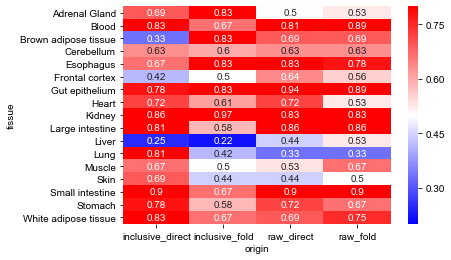

In [23]:
sns.heatmap(pi, cmap='bwr', vmin=0.2, vmax=0.8, annot=True)

if save_images:
    export.export_image(
        '{}/different_approaches.pdf'.format(out_path)
    )

In [24]:
bulk_no_tilt = [
    'Frontal cortex',
    'Lung',
    'Skin'
]



In [25]:
bulk_tilt = [
    'Adrenal Gland', 'Brown adipose tissue', 
    'Blood',  'Esophagus', 
    'Gut epithelium', 'Heart', 'Kidney', 
    'Large intestine', 'Liver',  'Muscle', 
    'Small intestine', 'Skin', 'Stomach', 
    'White adipose tissue', 'Cerebellum']

In [26]:
mega.loc[:, 'in_tilt'] = mega['tissue'].isin(bulk_tilt)

In [27]:


# sns.boxplot(
#     x='origin',
#     y='lower',
#     data=mega[mega['older']==24],
#     notch=True

# )
# plt.ylim([0, 1])

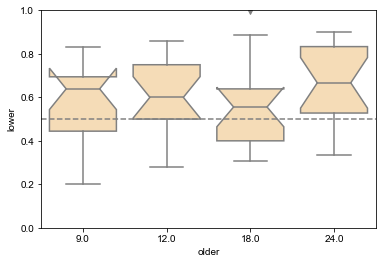

In [28]:

plt.axhline(y=0.5, color='grey', linestyle='--')


sns.boxplot(
    x='older',
    y='lower',
    data=mega[mega['origin']=='raw_fold'],
    notch=True,
    color='navajowhite'

)
plt.ylim([0, 1])

if save_images:
    export.export_image(
        '{}/lower_by_age.pdf'.format(out_path)
    )

In [29]:
pi = fr_raw_fold.pivot(
        index='tissue', columns='older', values='lower')

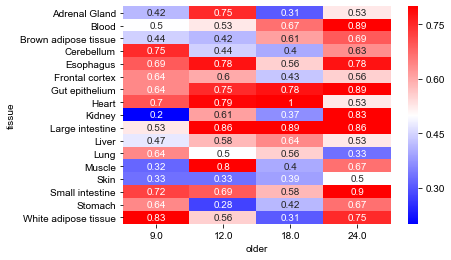

In [30]:

sns.heatmap(
    pi, 
    cmap='bwr', vmin=0.2, vmax=0.8, annot=True)

if save_images:
    export.export_image(
        '{}/heatmap_by_age.pdf'.format(out_path)
    )

In [31]:
pi.median()

older
9.0     0.638889
12.0    0.600000
18.0    0.555556
24.0    0.666667
dtype: float64

In [32]:
np.quantile(pi[24], 0.25)

0.5277777777777778

In [33]:
np.quantile(pi[24], 0.75)

0.8333333333333334

In [34]:
pi.sort_values(24)

older,9.0,12.0,18.0,24.0
tissue,,,,
Lung,0.638889,0.500000,0.555556,0.333333
Skin,0.333333,0.333333,0.388889,0.500000
Adrenal Gland,0.416667,0.750000,0.305556,0.527778
Heart,0.700000,0.791667,1.000000,0.527778
Liver,0.472222,0.583333,0.638889,0.527778
Frontal cortex,0.638889,0.600000,0.433333,0.555556
Cerebellum,0.750000,0.444444,0.400000,0.633333
Muscle,0.320000,0.800000,0.400000,0.666667
Stomach,0.638889,0.277778,0.416667,0.666667


In [35]:
fr_raw_fold.loc[:, 'in'] = fr_raw_fold['tissue'].isin(
    bulk_tilt
)

In [36]:
mega.groupby(['older', 'in_tilt']).agg(np.median).loc[24, :]

,lower
in_tilt,
False,0.458333
True,0.694444


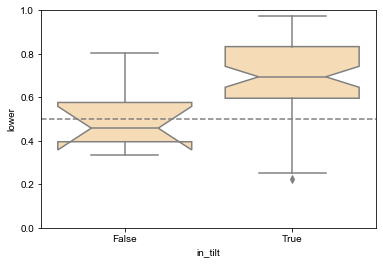

In [37]:
plt.axhline(y=0.5, color='grey', linestyle='--')


sns.boxplot(
    x='in_tilt',
    y='lower',
    data=mega[mega['older']==24],
    notch=True,
    color='navajowhite'
)


plt.ylim([0, 1])

if save_images:
    export.export_image(
        '{}/in_24_tilt.pdf'.format(out_path)
    )

In [38]:
from scipy.stats import mannwhitneyu

In [39]:
mannwhitneyu(
    mega[
    (mega['older']==24) &
        (mega['in_tilt']==False)
    ]['lower'],
    mega[
        (mega['older']==24) &
        (mega['in_tilt']==True)
    ]['lower'],
    alternative='two-sided')

MannwhitneyuResult(statistic=91.5, pvalue=0.004746662874045564)